In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from scipy import stats
from sklearn.preprocessing import StandardScaler
import matplotlib.dates as mdates
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.metrics import dtw
from keras.preprocessing.sequence import pad_sequences

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [2]:
df = pd.read_csv("/Users/a123/Desktop/CMU/Capstone/CRS-Detection/Datasets/final_data_clipped.csv")
df.head(5)

/var/folders/9q/_q_h4th94vj56dq6c3yv3gj80000gn/T/ipykernel_9741/1396069146.py:1: DtypeWarning: Columns (38,51,53,54,84,108,122,139,142,159,160,161) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/Users/a123/Desktop/CMU/Capstone/CRS-Detection/Datasets/final_data_clipped.csv")


,Unnamed: 0,patient_id,pr_display,spo2_display,resp_display,pulse_rate_obscount,pulse_rate_avg,pulse_rate_min,pulse_rate_max,pulse_rate_iqr,...,QC Deviation from median.1,Weight at time of infusion,precise_datetime,CRS intervention,CRS Grade (nurse),Temperature,SpO2,BP,HR,Temperature_C
0,0,7001,71 beats/min,96%,17%,10.0,70.01,66.63,71.52,2.88,...,0.047985,74.325238,2022-10-21 08:00:00.000000000,Tocilizumab x 1 on 1/22/24,1.0,100.9,WNL,WNL,WNL,38.277778
1,1,7001,71 beats/min,96%,17%,10.0,70.01,66.63,71.52,2.88,...,0.047985,74.325238,2022-10-21 08:00:00.000000000,Tocilizumab x 1 on 1/22/24,NaN,NaN,NaN,NaN,NaN,NaN
2,2,7001,71 beats/min,96%,17%,10.0,70.01,66.63,71.52,2.88,...,0.048813,74.325238,2022-10-21 08:14:32.727272704,Tocilizumab x 1 on 1/22/24,NaN,NaN,NaN,NaN,NaN,NaN
3,3,7001,71 beats/min,96%,17%,10.0,70.01,66.63,71.52,2.88,...,0.049641,74.325238,2022-10-21 08:29:05.454545408,Tocilizumab x 1 on 1/22/24,NaN,NaN,NaN,NaN,NaN,NaN
4,4,7001,71 beats/min,96%,17%,10.0,70.01,66.63,71.52,2.88,...,0.050469,74.325238,2022-10-21 08:43:38.181818112,Tocilizumab x 1 on 1/22/24,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
list(df.columns)

['Unnamed: 0',
 'patient_id',
 'pr_display',
 'spo2_display',
 'resp_display',
 'pulse_rate_obscount',
 'pulse_rate_avg',
 'pulse_rate_min',
 'pulse_rate_max',
 'pulse_rate_iqr',
 'spo2_obscount',
 'spo2_avg',
 'spo2_min',
 'spo2_max',
 'respiratory_rate_obscount',
 'respiratory_rate_avg',
 'respiratory_rate_min',
 'respiratory_rate_max',
 'covered_skin_temperature_obscount',
 'covered_skin_temperature_avg',
 'covered_skin_temperature_min',
 'covered_skin_temperature_max',
 'covered_axil_temperature_obscount',
 'covered_axil_temperature_avg',
 'covered_axil_temperature_min',
 'covered_axil_temperature_max',
 'motion_obscount',
 'motion_avg',
 'step_count_sum',
 'step_count_obscount',
 'time',
 'datetime',
 'PT_ID',
 'Sample ID',
 'Agent (JNJ/BMS/Caribou)',
 'Date of CAR-T infusion',
 'Age',
 'Date of Sample',
 'Days in relation to CAR-T  infusion',
 'Patient experienced CRS at any point (Yes/No)',
 'CRS on date (0 No, 1 Yes)',
 'CRS Grade ',
 'ICANs on date (0 -no, 1 yes)',
 'TOCI give

In [4]:
columns_test_1 = ['PT_ID','CRS on date (0 No, 1 Yes)','Agent (JNJ/BMS/Caribou)','datetime', 'spo2_avg', 'pulse_rate_avg','respiratory_rate_avg', 'covered_skin_temperature_avg','IL8','IL6','CXCL10','IFN-gamma','CCL23', 'CASP-8',
 'CXCL13'] 
df_subset = df[columns_test_1]
df_subset.head(5)

,PT_ID,"CRS on date (0 No, 1 Yes)",Agent (JNJ/BMS/Caribou),datetime,spo2_avg,pulse_rate_avg,respiratory_rate_avg,covered_skin_temperature_avg,IL8,IL6,CXCL10,IFN-gamma,CCL23,CASP-8,CXCL13
0,7001,0,BMS,2022-01-21 23:30:00,97.83,70.01,24.35,27.650,5.570850,4.754540,9.135090,5.938620,10.893300,4.387440,6.721580
1,7001,1,BMS,2022-10-21 16:02:00,97.83,70.01,24.35,27.650,5.570850,4.754540,9.135090,5.938620,10.893300,4.387440,6.721580
2,7001,1,BMS,2022-10-21 16:03:00,97.83,70.01,19.86,27.735,5.575702,4.773422,9.158341,6.003697,10.897528,4.403390,6.724164
3,7001,1,BMS,2022-10-21 17:42:00,97.83,70.01,15.37,27.820,5.580553,4.792303,9.181591,6.068774,10.901756,4.419340,6.726747
4,7001,1,BMS,2022-10-21 17:43:00,97.83,70.01,11.77,27.780,5.585405,4.811185,9.204842,6.133852,10.905983,4.435289,6.729331


In [5]:
df_JNJ = df_subset[(df_subset['Agent (JNJ/BMS/Caribou)']=='JNJ') | (df_subset['Agent (JNJ/BMS/Caribou)']=='JNJ OOS')]
df_BMS = df_subset[(df_subset['Agent (JNJ/BMS/Caribou)']=='BMS')]

In [6]:
# Individualize the data
# Create a baseline dataframe
data = df_JNJ.copy()

baseline = data.groupby('PT_ID').first().reset_index()

# Subtract the baseline values for numeric columns
columns_to_individualize = [col for col in columns_test_1 if col not in ['PT_ID', 'CRS on date (0 No, 1 Yes)', 'Agent (JNJ/BMS/Caribou)','datetime']]

for col in columns_to_individualize:
    data[col] = pd.to_numeric(data[col], errors='coerce')
    data[col] = data[col] - data.groupby('PT_ID')[col].transform('first')

data.head()


,PT_ID,"CRS on date (0 No, 1 Yes)",Agent (JNJ/BMS/Caribou),datetime,spo2_avg,pulse_rate_avg,respiratory_rate_avg,covered_skin_temperature_avg,IL8,IL6,CXCL10,IFN-gamma,CCL23,CASP-8,CXCL13
42639,7004,0,JNJ,2022-12-05 15:44:00,0.0,0.0,0.000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
42640,7004,0,JNJ,2022-12-05 15:45:00,0.0,0.0,0.000,0.00,0.002603,-0.000316,-0.001205,-0.000085,-0.000287,-0.005952,-0.000051
42641,7004,0,JNJ,2022-12-05 15:46:00,0.0,0.0,7.210,0.01,0.005205,-0.000633,-0.002410,-0.000171,-0.000574,-0.011904,-0.000102
42642,7004,0,JNJ,2022-12-05 15:47:00,0.0,0.0,4.605,0.08,0.007808,-0.000949,-0.003616,-0.000256,-0.000861,-0.017857,-0.000153
42643,7004,0,JNJ,2022-12-05 15:48:00,0.0,0.0,2.000,0.02,0.010410,-0.001265,-0.004821,-0.000342,-0.001148,-0.023809,-0.000203


In [7]:
# Define the window size for rolling statistics (e.g., past 6 hours)
window_size = 6
lag_size = 6

# Sort data by patient ID and datetime
data = data.sort_values(by=['PT_ID', 'datetime'])

# Function to create lagged features and rolling statistics
def add_past_features(data, columns,lag_size):
    for col in columns:
        # Add lagged values 
        for lag in range(1, lag_size + 1):
            data[f'{col}_lag_{lag}'] = data.groupby('PT_ID')[col].shift(lag)
        
        # Add rolling statistics
        data[f'{col}_rolling_mean_{lag_size}'] = data.groupby('PT_ID')[col].rolling(lag_size, min_periods=1).mean().reset_index(level=0, drop=True)
        data[f'{col}_rolling_std_{lag_size}'] = data.groupby('PT_ID')[col].rolling(lag_size, min_periods=1).std().reset_index(level=0, drop=True)
        data[f'{col}_rolling_min_{lag_size}'] = data.groupby('PT_ID')[col].rolling(lag_size, min_periods=1).min().reset_index(level=0, drop=True)
        data[f'{col}_rolling_max_{lag_size}'] = data.groupby('PT_ID')[col].rolling(lag_size, min_periods=1).max().reset_index(level=0, drop=True)


    return data

# Add past features for selected columns
columns_to_process = [col for col in columns_test_1 if col not in ['PT_ID','CRS on date (0 No, 1 Yes)','Agent (JNJ/BMS/Caribou)','datetime']]
data = add_past_features(data, columns_to_process, lag_size)


/var/folders/9q/_q_h4th94vj56dq6c3yv3gj80000gn/T/ipykernel_9741/4242038772.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'{col}_rolling_std_{lag_size}'] = data.groupby('PT_ID')[col].rolling(lag_size, min_periods=1).std().reset_index(level=0, drop=True)
/var/folders/9q/_q_h4th94vj56dq6c3yv3gj80000gn/T/ipykernel_9741/4242038772.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'{col}_rolling_min_{lag_size}'] = data.groupby('PT_ID')[col].rolling(lag_size, min_periods=1).min().reset_index(level=0, drop=True)
/v

In [8]:
list(data.columns)

['PT_ID',
 'CRS on date (0 No, 1 Yes)',
 'Agent (JNJ/BMS/Caribou)',
 'datetime',
 'spo2_avg',
 'pulse_rate_avg',
 'respiratory_rate_avg',
 'covered_skin_temperature_avg',
 'IL8',
 'IL6',
 'CXCL10',
 'IFN-gamma',
 'CCL23',
 'CASP-8',
 'CXCL13',
 'spo2_avg_lag_1',
 'spo2_avg_lag_2',
 'spo2_avg_lag_3',
 'spo2_avg_lag_4',
 'spo2_avg_lag_5',
 'spo2_avg_lag_6',
 'spo2_avg_rolling_mean_6',
 'spo2_avg_rolling_std_6',
 'spo2_avg_rolling_min_6',
 'spo2_avg_rolling_max_6',
 'pulse_rate_avg_lag_1',
 'pulse_rate_avg_lag_2',
 'pulse_rate_avg_lag_3',
 'pulse_rate_avg_lag_4',
 'pulse_rate_avg_lag_5',
 'pulse_rate_avg_lag_6',
 'pulse_rate_avg_rolling_mean_6',
 'pulse_rate_avg_rolling_std_6',
 'pulse_rate_avg_rolling_min_6',
 'pulse_rate_avg_rolling_max_6',
 'respiratory_rate_avg_lag_1',
 'respiratory_rate_avg_lag_2',
 'respiratory_rate_avg_lag_3',
 'respiratory_rate_avg_lag_4',
 'respiratory_rate_avg_lag_5',
 'respiratory_rate_avg_lag_6',
 'respiratory_rate_avg_rolling_mean_6',
 'respiratory_rate_avg_r

In [9]:
data.shape

(171893, 125)

In [10]:
from datetime import timedelta
# Ensure datetime is sorted for each patient
data['datetime'] = pd.to_datetime(data['datetime'])
data = data.sort_values(by=['PT_ID', 'datetime'])

# Create a shifted DataFrame to check CRS 6 hours ahead
shifted_data = data[['PT_ID', 'datetime', 'CRS on date (0 No, 1 Yes)']].copy()
shifted_data['datetime'] = shifted_data['datetime'] + timedelta(hours=6)
shifted_data.rename(columns={'CRS on date (0 No, 1 Yes)': 'CRS_in_6_hours'}, inplace=True)

# Merge shifted data back to the original DataFrame
data = pd.merge(data, shifted_data, on=['PT_ID', 'datetime'], how='left')

# Fill NaN values with 0 (no CRS detected in 6 hours)
data['CRS_in_6_hours'] = data['CRS_in_6_hours'].fillna(0).astype(int)

In [11]:
data.shape

(171894, 126)

In [12]:
data

,PT_ID,"CRS on date (0 No, 1 Yes)",Agent (JNJ/BMS/Caribou),datetime,spo2_avg,pulse_rate_avg,respiratory_rate_avg,covered_skin_temperature_avg,IL8,IL6,...,CXCL13_lag_2,CXCL13_lag_3,CXCL13_lag_4,CXCL13_lag_5,CXCL13_lag_6,CXCL13_rolling_mean_6,CXCL13_rolling_std_6,CXCL13_rolling_min_6,CXCL13_rolling_max_6,CRS_in_6_hours
0,7004,0,JNJ,2022-12-05 15:44:00,0.000,0.00,0.000,0.00,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,0.00000,0
1,7004,0,JNJ,2022-12-05 15:45:00,0.000,0.00,0.000,0.00,0.002603,-0.000316,...,NaN,NaN,NaN,NaN,NaN,-0.000025,0.000036,-0.000051,0.00000,0
2,7004,0,JNJ,2022-12-05 15:46:00,0.000,0.00,7.210,0.01,0.005205,-0.000633,...,0.000000,NaN,NaN,NaN,NaN,-0.000051,0.000051,-0.000102,0.00000,0
3,7004,0,JNJ,2022-12-05 15:47:00,0.000,0.00,4.605,0.08,0.007808,-0.000949,...,-0.000051,0.000000,NaN,NaN,NaN,-0.000076,0.000066,-0.000153,0.00000,0
4,7004,0,JNJ,2022-12-05 15:48:00,0.000,0.00,2.000,0.02,0.010410,-0.001265,...,-0.000102,-0.000051,0.000000,NaN,NaN,-0.000102,0.000080,-0.000203,0.00000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171889,7028,0,JNJ,2023-10-11 08:01:00,10.400,-86.99,4.590,-1.39,0.061630,2.605260,...,-1.932168,-1.932192,-1.932216,-1.932240,-1.932264,-1.932180,0.000045,-1.932240,-1.93212,0
171890,7028,0,JNJ,2023-10-11 08:02:00,11.000,-86.48,8.430,-1.34,0.061630,2.605260,...,-1.932144,-1.932168,-1.932192,-1.932216,-1.932240,-1.932160,0.000039,-1.932216,-1.93212,0
171891,7028,0,JNJ,2023-10-11 08:03:00,10.970,-87.77,4.160,-1.29,0.061630,2.605260,...,-1.932120,-1.932144,-1.932168,-1.932192,-1.932216,-1.932144,0.000030,-1.932192,-1.93212,0
171892,7028,0,JNJ,2023-10-11 08:04:00,10.890,-89.50,2.710,-1.29,0.061630,2.605260,...,-1.932120,-1.932120,-1.932144,-1.932168,-1.932192,-1.932132,0.000020,-1.932168,-1.93212,0


In [13]:
data[data['CRS_in_6_hours']==1]

,PT_ID,"CRS on date (0 No, 1 Yes)",Agent (JNJ/BMS/Caribou),datetime,spo2_avg,pulse_rate_avg,respiratory_rate_avg,covered_skin_temperature_avg,IL8,IL6,...,CXCL13_lag_2,CXCL13_lag_3,CXCL13_lag_4,CXCL13_lag_5,CXCL13_lag_6,CXCL13_rolling_mean_6,CXCL13_rolling_std_6,CXCL13_rolling_min_6,CXCL13_rolling_max_6,CRS_in_6_hours
40052,7011,1,JNJ,2023-02-17 22:22:00,2.186667,19.811765,-4.964706,14.290588,2.865913,6.974972,...,1.033101,1.000672,0.968243,0.935815,0.903386,1.016886,0.060668,0.935815,1.097958,1
40064,7011,1,JNJ,2023-02-18 00:31:00,0.226667,8.058824,-4.343529,10.972941,2.290956,5.551668,...,1.422244,1.389816,1.357387,1.324958,1.292530,1.406030,0.060668,1.324958,1.487102,1
40073,7011,1,JNJ,2023-02-18 04:20:00,-0.580000,3.074286,-0.404286,11.910000,1.859738,4.484191,...,1.714102,1.681673,1.649245,1.616816,1.584387,1.697888,0.060668,1.616816,1.778959,1
40079,7011,1,JNJ,2023-02-18 07:00:00,-1.754639,-1.045361,4.254255,12.202473,1.572260,3.772539,...,1.908674,1.876245,1.843817,1.811388,1.778959,1.892460,0.060668,1.811388,1.973531,1
77466,7017,1,JNJ,2023-05-05 02:01:00,4.950000,0.000000,2.440000,1.460000,0.241725,1.620922,...,1.393127,1.393280,1.393433,1.393587,1.393740,1.393203,0.000287,1.392820,1.393587,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167300,7028,0,JNJ,2023-10-06 13:56:00,5.214545,-65.977812,4.830000,-1.920000,2.207375,4.606569,...,0.248529,0.248867,0.249205,0.249543,0.249881,0.248698,0.000633,0.247852,0.249543,1
167301,7028,0,JNJ,2023-10-06 13:57:00,5.290909,-65.541875,2.406667,-1.843333,2.207031,4.606143,...,0.248191,0.248529,0.248867,0.249205,0.249543,0.248360,0.000633,0.247514,0.249205,1
167302,7028,0,JNJ,2023-10-06 13:58:00,5.367273,-65.105937,-0.016667,-1.766667,2.206687,4.605717,...,0.247852,0.248191,0.248529,0.248867,0.249205,0.248021,0.000633,0.247176,0.248867,1
167303,7028,0,JNJ,2023-10-06 13:59:00,5.443636,-64.670000,-2.440000,-1.690000,2.206343,4.605291,...,0.247514,0.247852,0.248191,0.248529,0.248867,0.247683,0.000633,0.246838,0.248529,1


In [14]:
data[data['CRS_in_6_hours']==1].head(10)

,PT_ID,"CRS on date (0 No, 1 Yes)",Agent (JNJ/BMS/Caribou),datetime,spo2_avg,pulse_rate_avg,respiratory_rate_avg,covered_skin_temperature_avg,IL8,IL6,...,CXCL13_lag_2,CXCL13_lag_3,CXCL13_lag_4,CXCL13_lag_5,CXCL13_lag_6,CXCL13_rolling_mean_6,CXCL13_rolling_std_6,CXCL13_rolling_min_6,CXCL13_rolling_max_6,CRS_in_6_hours
40052,7011,1,JNJ,2023-02-17 22:22:00,2.186667,19.811765,-4.964706,14.290588,2.865913,6.974972,...,1.033101,1.000672,0.968243,0.935815,0.903386,1.016886,0.060668,0.935815,1.097958,1
40064,7011,1,JNJ,2023-02-18 00:31:00,0.226667,8.058824,-4.343529,10.972941,2.290956,5.551668,...,1.422244,1.389816,1.357387,1.324958,1.292530,1.406030,0.060668,1.324958,1.487102,1
40073,7011,1,JNJ,2023-02-18 04:20:00,-0.580000,3.074286,-0.404286,11.910000,1.859738,4.484191,...,1.714102,1.681673,1.649245,1.616816,1.584387,1.697888,0.060668,1.616816,1.778959,1
40079,7011,1,JNJ,2023-02-18 07:00:00,-1.754639,-1.045361,4.254255,12.202473,1.572260,3.772539,...,1.908674,1.876245,1.843817,1.811388,1.778959,1.892460,0.060668,1.811388,1.973531,1
77466,7017,1,JNJ,2023-05-05 02:01:00,4.950000,0.000000,2.440000,1.460000,0.241725,1.620922,...,1.393127,1.393280,1.393433,1.393587,1.393740,1.393203,0.000287,1.392820,1.393587,1
77467,7017,1,JNJ,2023-05-05 02:02:00,5.010000,0.000000,3.780000,1.450000,0.242660,1.620503,...,1.392973,1.393127,1.393280,1.393433,1.393587,1.393050,0.000287,1.392667,1.393433,1
77468,7017,1,JNJ,2023-05-05 02:03:00,5.070000,0.000000,0.460000,1.460000,0.243594,1.620084,...,1.392820,1.392973,1.393127,1.393280,1.393433,1.392897,0.000287,1.392513,1.393280,1
77469,7017,1,JNJ,2023-05-05 02:04:00,4.620000,0.000000,4.090000,1.460000,0.244529,1.619665,...,1.392667,1.392820,1.392973,1.393127,1.393280,1.392743,0.000287,1.392360,1.393127,1
77470,7017,1,JNJ,2023-05-05 02:05:00,4.400000,0.000000,3.640000,1.460000,0.245463,1.619246,...,1.392513,1.392667,1.392820,1.392973,1.393127,1.392590,0.000287,1.392207,1.392973,1
77471,7017,1,JNJ,2023-05-05 02:06:00,4.770000,0.000000,5.200000,1.450000,0.246398,1.618827,...,1.392360,1.392513,1.392667,1.392820,1.392973,1.392437,0.000287,1.392053,1.392820,1


In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Ensure datetime is in datetime format
data['datetime'] = pd.to_datetime(data['datetime'])

# Calculate 0.8 quantile cutoff for each patient
quantile_cutoffs = data.groupby('PT_ID')['datetime'].quantile(0.8).reset_index()
quantile_cutoffs.columns = ['PT_ID', 'cutoff_date']

# Merge the cutoff dates back into the original dataframe
data = data.merge(quantile_cutoffs, on='PT_ID')

# Create train and test datasets based on the cutoff date
train_data = data[data['datetime'] < data['cutoff_date']]
test_data = data[data['datetime'] >= data['cutoff_date']]

# Separate features and target
X_train = train_data.drop(columns=['PT_ID', 'datetime', 'CRS on date (0 No, 1 Yes)', 'Agent (JNJ/BMS/Caribou)', 'CRS_in_6_hours', 'cutoff_date'])
y_train = train_data['CRS_in_6_hours']

X_test = test_data.drop(columns=['PT_ID', 'datetime', 'CRS on date (0 No, 1 Yes)', 'Agent (JNJ/BMS/Caribou)', 'CRS_in_6_hours', 'cutoff_date'])
y_test = test_data['CRS_in_6_hours']



In [16]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import roc_auc_score, classification_report

# Convert data to DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Calculate class weights
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=y_train  # Target variable in the training set
)

# Set the scale_pos_weight parameter in XGBoost
scale_pos_weight = class_weights[1] / class_weights[0]

# XGBoost parameters
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'max_depth': 6,
    'learning_rate': 0.1,
    'n_estimators': 100,
    'scale_pos_weight': scale_pos_weight  # Add the class imbalance weight
}

# Train the XGBoost model
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
model = xgb.train(params, dtrain, num_boost_round=100)


# Make predictions
y_pred = (model.predict(dtest) > 0.5).astype(int)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


# Predict probabilities for AUC-ROC
y_prob = model.predict(dtest)
auc = roc_auc_score(y_test, y_prob)
print("AUC-ROC Score:", auc)



: 

<Figure size 1000x800 with 0 Axes>

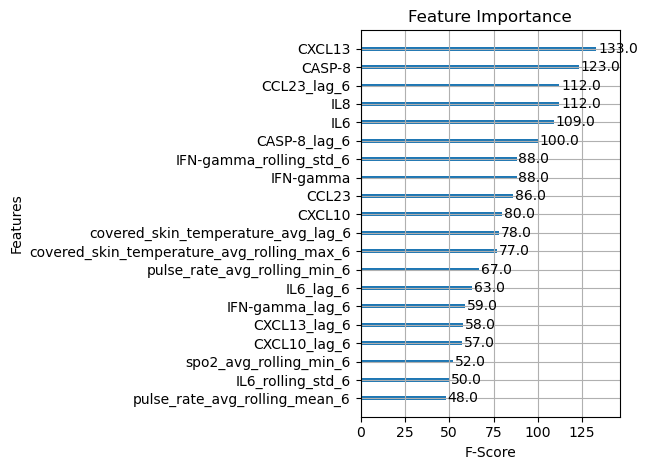

In [602]:
import matplotlib.pyplot as plt
import xgboost as xgb

# Plot feature importance
plt.figure(figsize=(10, 8))
xgb.plot_importance(model, max_num_features=20)  # Show top 20 features
plt.title('Feature Importance')
plt.xlabel('F-Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()


In [603]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
import xgboost as xgb

# Step 2: Apply Random Oversampling
oversampler = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

# Check the class distribution after oversampling
print("Class distribution after oversampling:")
print(pd.Series(y_train_resampled).value_counts())

# Step 3: Convert to XGBoost DMatrix
dtrain = xgb.DMatrix(X_train_resampled, label=y_train_resampled)
dtest = xgb.DMatrix(X_test, label=y_test)

# Step 4: Define XGBoost Parameters
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'max_depth': 6,
    'learning_rate': 0.1,
    'n_estimators': 100
}

# Step 5: Train the XGBoost Model
model = xgb.train(params, dtrain, num_boost_round=100)

# Step 6: Predict and Evaluate
y_prob = model.predict(dtest)  # Predicted probabilities
y_pred = (y_prob > 0.5).astype(int)  # Convert probabilities to binary predictions

print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC-ROC Score:", roc_auc_score(y_test, y_prob))
print("Classification Report:\n", classification_report(y_test, y_pred))


Class distribution after oversampling:
CRS_in_6_hours
0    124387
1    124387
Name: count, dtype: int64


/Users/a123/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [19:36:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.9318637857329805
AUC-ROC Score: 0.9133356446823719
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.98      0.96     30380
           1       0.82      0.53      0.65      4007

    accuracy                           0.93     34387
   macro avg       0.88      0.76      0.80     34387
weighted avg       0.93      0.93      0.93     34387



In [604]:
X_train_resampled.dtypes

spo2_avg                        float64
pulse_rate_avg                  float64
respiratory_rate_avg            float64
covered_skin_temperature_avg    float64
IL8                             float64
                                 ...   
CXCL13_lag_6                    float64
CXCL13_rolling_mean_6           float64
CXCL13_rolling_std_6            float64
CXCL13_rolling_min_6            float64
CXCL13_rolling_max_6            float64
Length: 121, dtype: object

<Figure size 1000x800 with 0 Axes>

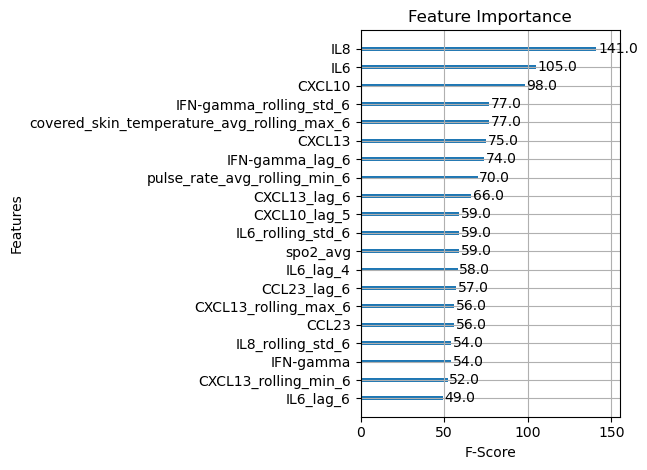

In [605]:
import matplotlib.pyplot as plt
import xgboost as xgb

# Plot feature importance
plt.figure(figsize=(10, 8))
xgb.plot_importance(model, max_num_features=20)  # Show top 20 features
plt.title('Feature Importance')
plt.xlabel('F-Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()
